In [1]:
import os, random, glob, pickle, collections
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

from skimage.data import imread
from skimage.io import imshow,imsave
import cv2
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import math

Using TensorFlow backend.


In [2]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
TRAIN_CROP_DIR = '../data/train_crop/'
TEST_CROP_DIR = '../data/test_stg1_crop/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ROWS = 270
COLS = 480
BatchSize = 64
LearningRate = 1e-4
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
#crop and cache to TRAIN_CROP_DIR by BBannotations
if not os.path.exists(TRAIN_CROP_DIR):
    os.mkdir(TRAIN_CROP_DIR)

for c in FISH_CLASSES:
    TRAIN_CROP_DIR_c = TRAIN_CROP_DIR + '{}/'.format(c)
    if not os.path.exists(TRAIN_CROP_DIR_c):
        os.mkdir(TRAIN_CROP_DIR_c)
    files = glob.glob(TRAIN_CROP_DIR_c+'*')
    for f in files:
        os.remove(f)
        
crop_classes=FISH_CLASSES[:]
crop_classes.remove('NoF')
count = {}

for c in crop_classes:
    j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
    for l in j: 
        filename = l["filename"]
        head, tail = os.path.split(filename)
        basename, file_extension = os.path.splitext(tail) 
        image = Image.open(TRAIN_DIR+c+'/'+tail)
        for i in range(len(l["annotations"])):
            a = l["annotations"][i]
            file_crop = TRAIN_CROP_DIR + '{}/'.format(a["class"])+c+'_'+basename+'_{}_'.format(i)+a["class"]+'.jpg'
            xmin = (a["x"])
            ymin = (a["y"])
            width = (a["width"])
            height = (a["height"])
            xmax = xmin + width
            ymax = ymin + height
            #save cropped img
            cropped = image.crop((max(xmin,0), max(ymin,0), xmax, ymax))
            #cropped = image[max(ymin,0):ymax, max(xmin,0):xmax]
            width_cropped, height_cropped = cropped.size
            if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
            cropped.save(file_crop)
            if a["class"] != c: print(file_crop)
    count[c] = len(os.listdir(TRAIN_CROP_DIR+c))

#crop and cache to TRAIN_CROP_DIR/NoF by RFCN
#crop images by detections_full_AGNOSTICnms.pkl

RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.8
outputs = []

# for im in range(len(detections_full_AGNOSTICnms)):
#     outputs_im = []
#     detects_im = detections_full_AGNOSTICnms[im]
#     for i in range(len(detects_im)):
#         if np.max(detects_im[i,4]) >= CONF_THRESH:
#             outputs_im.append(detects_im[i,:]) 
#     outputs_im = np.asarray(outputs_im)
#     outputs_im[np.random.randint(outputs_im.shape[0], size=1), :]
#     outputs.append(outputs_im[np.random.randint(outputs_im.shape[0], size=1), :])

for im in range(len(detections_full_AGNOSTICnms)):
    outputs_im = []
    detects_im = detections_full_AGNOSTICnms[im]
    for i in range(len(detects_im)):
        if np.max(detects_im[i,5:]) <= CONF_THRESH:
            outputs_im.append(detects_im[i,:]) 
    outputs_im = np.asarray(outputs_im)
    ind = np.argmax(np.max(outputs_im[:,5:], axis=1))
    if outputs_im[ind,4] > 0.99:
        outputs.append(outputs_im[[ind], :])
    else:
        outputs.append(np.ndarray((0,0)))

train_outputs = outputs[1000:]

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
train_files = [im[:-1]+'.jpg' for im in ims][1000:]

for i in range(len(train_outputs)):
    if i%1000 == 0:
        print(i)
    filename = train_files[i]
    bboxes = train_outputs[i]
    basename, file_extension = os.path.splitext(filename) 
    image = Image.open(TEST_DIR+filename)
    for j in range(len(bboxes)):
        bbox = bboxes[j]
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2]
        ymax = bbox[3]
        file_crop = TRAIN_CROP_DIR+'NoF/'+basename+'_{}_'.format(j)+'.jpg'
        cropped = image.crop((xmin, ymin, xmax, ymax))
        width_cropped, height_cropped = cropped.size
        if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
        cropped.save(file_crop)  

count['NoF'] = len(os.listdir(TRAIN_CROP_DIR+'NoF'))
print(count)

[[  7.67513916e+02   2.89753418e+01   1.06410815e+03   5.55451782e+02
    9.94154513e-01   5.61167719e-03   6.62105667e-05   6.65973312e-06
    5.60094086e-05   5.32696067e-05   1.22164593e-05   3.94710296e-05]]
[[  5.71809814e+02   4.80568481e+02   7.08876221e+02   6.67665771e+02
    9.96306896e-01   9.24271808e-06   7.13401314e-05   3.91321555e-05
    1.09528182e-05   1.57694467e-06   3.55789998e-05   3.52531718e-03]]
[[  4.29118225e+02   2.60042633e+02   4.98336243e+02   3.53363678e+02
    9.99312282e-01   4.66967322e-04   4.74928584e-06   2.38211669e-05
    1.58683943e-05   7.01384124e-05   2.78701991e-05   7.82187126e-05]]
[[  8.72523682e+02   2.85332001e+02   9.43036011e+02   3.49181000e+02
    9.99989152e-01   9.76432693e-06   8.63876650e-08   6.31754560e-08
    2.38287100e-07   2.33320350e-07   1.03672122e-07   1.98004528e-07]]
[[  7.15904907e+02   1.07656021e+02   8.22897339e+02   2.28620773e+02
    9.99998212e-01   1.39193128e-06   1.07248317e-08   4.70517953e-08
    6.596223

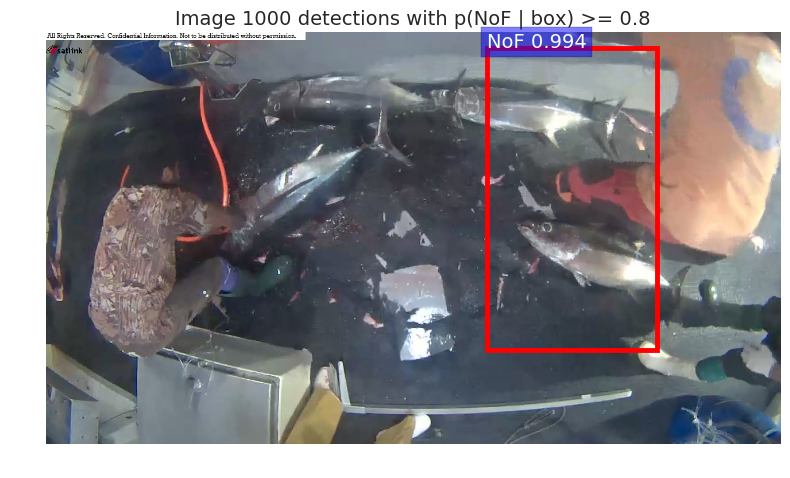

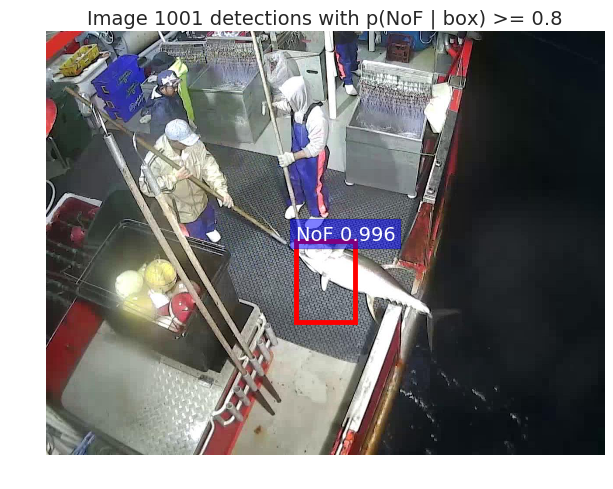

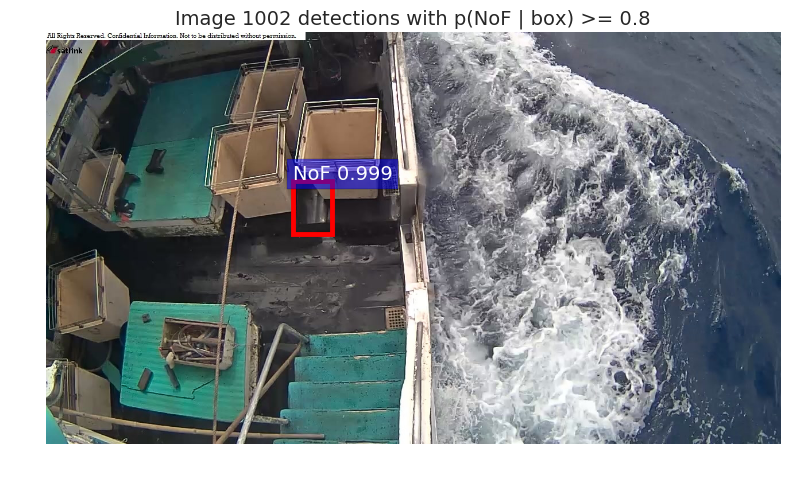

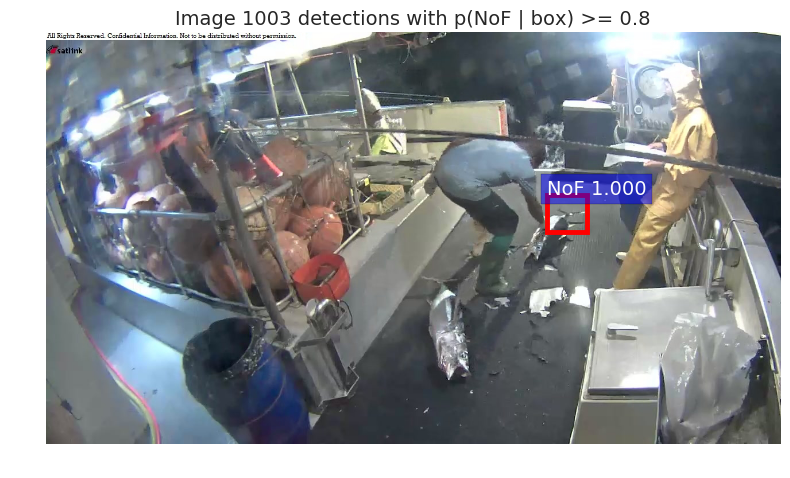

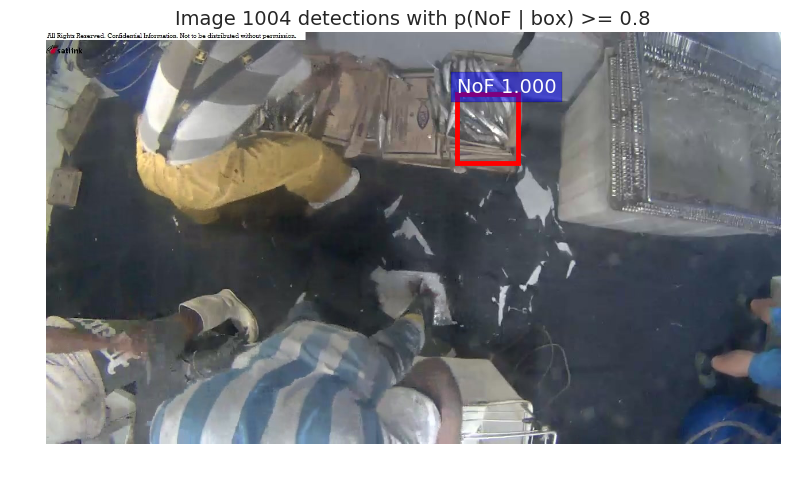

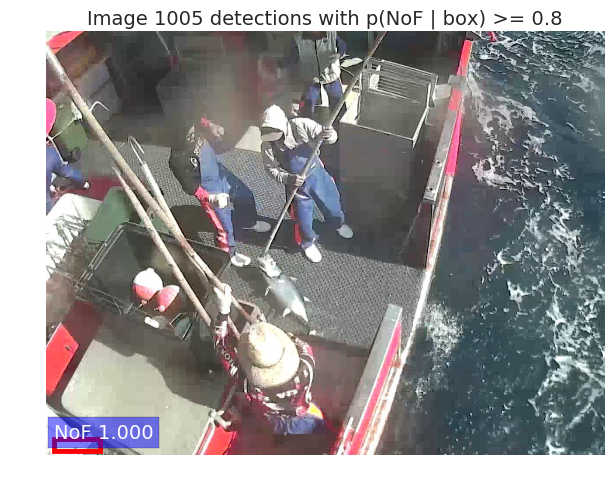

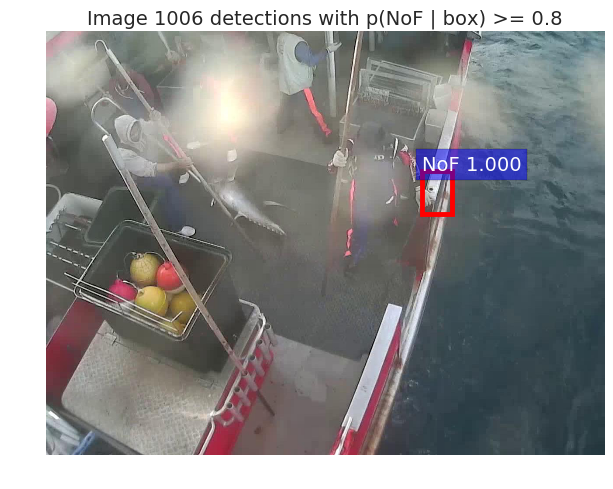

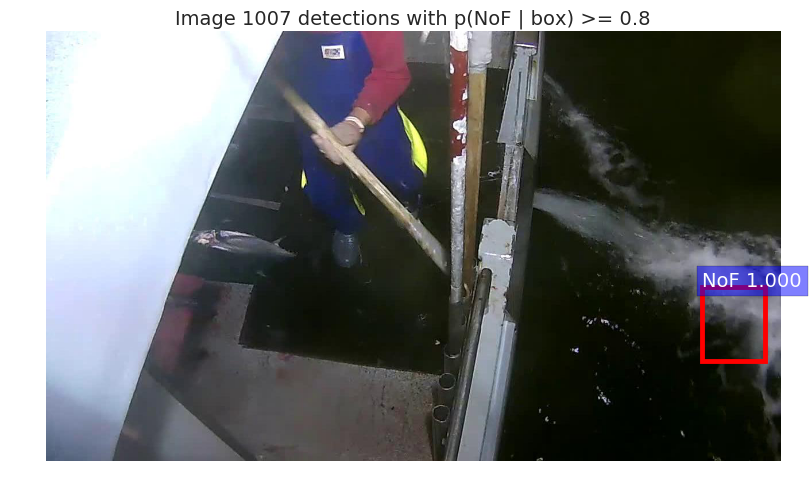

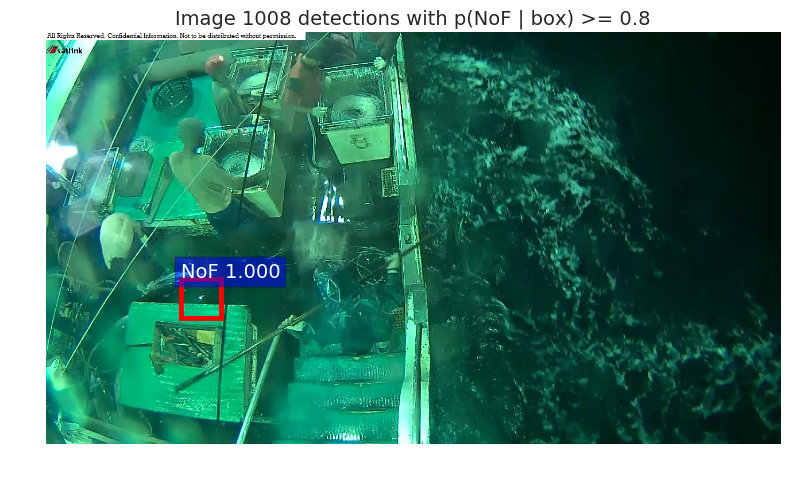

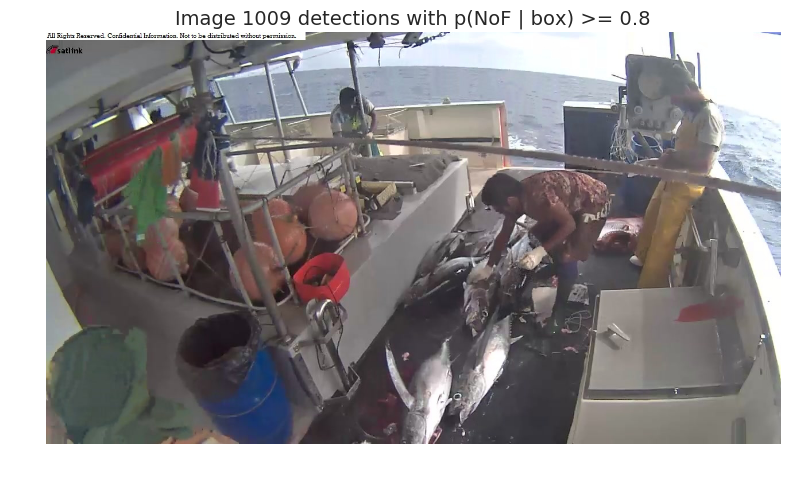

In [35]:
#visualize test image crop
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
train_files = [im[:-1]+'.jpg' for im in ims][1000:]

for j in range(10):
    dets = train_outputs[j]
    print(dets)
    im = Image.open("../RFCN/JPEGImages/"+train_files[j])
    im = np.asarray(im)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.imshow(im, aspect='equal')
    for i in range(dets.shape[0]):
        bbox = dets[i, :4]
        score = np.amax(dets[i,4:])
        index = np.argmax(dets[i,4:])
        class_name = FISH_CLASSES[index]
        #if not (bbox[0] == 0 and bbox[1] == 0 and bbox[2] == 0 and bbox[3] == 0):
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5))
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('Image {} detections with '
                  'p({} | box) >= {:.1f}').format(j, class_name, CONF_THRESH),fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [ ]:
im = Image.open('../data/train_crop/ALB/SHARK_img_06082_2_ALB.jpg')
imshow(np.asarray(im))

im_sizes = []
for c in crop_classes:
    TRAIN_CROP_DIR_c = TRAIN_CROP_DIR + '{}/'.format(c)
    files = glob.glob(TRAIN_CROP_DIR_c+'*')
    for file in files:
        im = Image.open(file)
        #size = (width, height)
        size = im.size
        im_sizes.append(size)
im_sizes = np.asarray(im_sizes)

len(im_sizes)

np.mean(im_sizes[:,1]/im_sizes[:,0])

plt.hist(im_sizes[:,1]/im_sizes[:,0], bins=10)

plt.scatter(im_sizes[:,0],im_sizes[:,1]) 

In [36]:
#Loading data
import pickle

def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_CROP_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_train_BBCrop_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_train = pickle.load(f)
    X_train = data_train['X_train']
    y_train = data_train['y_train']
else:
    print ('Loading data from original images. Generating data_train_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))
    
    files = []
    y_train = []

    for fish in FISH_CLASSES:
        fish_files = get_images(fish)
        files.extend(fish_files)

        y_fish = np.tile(fish, len(fish_files))
        y_train.extend(y_fish)
        #print("{0} photos of {1}".format(len(fish_files), fish))

    y_train = np.array(y_train)
    X_train = np.ndarray((len(files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(files): 
        X_train[i] = read_image(TRAIN_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

    #X_train = X_train / 255.
    #print(X_train.shape)

    # One Hot Encoding Labels
    y_train = le.transform(y_train)
    y_train = np_utils.to_categorical(y_train)
    
    #save data to file
    data_train = {'X_train': X_train,'y_train': y_train }

    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_train, f)

#rescale
X_train = X_train / 255.
X_train = X_train.astype(np.float32)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=None, stratify=y_train)

Loading data from original images. Generating data_train_BBCrop_270_480.pickle.
Processed 0 of 7506
Processed 1000 of 7506
Processed 2000 of 7506
Processed 3000 of 7506
Processed 4000 of 7506
Processed 5000 of 7506
Processed 6000 of 7506
Processed 7000 of 7506


In [37]:
#data preprocessing

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    #featurewise_std_normalization=True,
    #rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

#train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BatchSize, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(
    featurewise_center=True,
    #featurewise_std_normalization=True)
    #rescale=1./255
    

valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BatchSize, shuffle=True, seed=None)

In [38]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath='./checkpoints/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


In [44]:
#Resnet50
#stg1 training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=30, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Epoch 1/300
5952/6004 [============================>.] - ETA: 1s - loss: 2.6740 - acc: 0.1252

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss did not improve
6016/6004 [==============================] - 262s - loss: 2.6672 - acc: 0.1263 - val_loss: 1.9209 - val_acc: 0.3118
Epoch 2/300
6016/6004 [==============================] - 253s - loss: 2.2160 - acc: 0.2281 - val_loss: 1.8760 - val_acc: 0.2454
Epoch 3/300
6044/6004 [==============================] - 257s - loss: 1.9822 - acc: 0.3119 - val_loss: 1.8566 - val_acc: 0.1081
Epoch 4/300
6016/6004 [==============================] - 253s - loss: 1.9187 - acc: 0.3263 - val_loss: 1.8295 - val_acc: 0.2520
Epoch 5/300
6016/6004 [==============================] - 253s - loss: 1.8094 - acc: 0.3688 - val_loss: 1.8333 - val_acc: 0.3496
Epoch 6/300
6044/6004 [==============================] - 259s - loss: 1.7468 - acc: 0.3873 - val_loss: 1.8015 - val_acc: 0.3997
Epoch 7/300
6016/6004 [==============================] - 253s - loss: 1.7073 - acc: 0.4023 - val_loss: 1.7632 - val_acc: 0.4310
Epoch 8/300
6016/6004 [==============================] - 252s - loss: 1.6841 -

In [45]:
#Resnet50
#stg2 training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:164]:
   layer.trainable = False
for layer in model.layers[164:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./checkpoints/weights.052-0.9191.hdf5
0 input_3
1 zeropadding2d_3
2 conv1
3 bn_conv1
4 activation_99
5 maxpooling2d_3
6 res2a_branch2a
7 bn2a_branch2a
8 activation_100
9 res2a_branch2b
10 bn2a_branch2b
11 activation_101
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 merge_33
17 activation_102
18 res2b_branch2a
19 bn2b_branch2a
20 activation_103
21 res2b_branch2b
22 bn2b_branch2b
23 activation_104
24 res2b_branch2c
25 bn2b_branch2c
26 merge_34
27 activation_105
28 res2c_branch2a
29 bn2c_branch2a
30 activation_106
31 res2c_branch2b
32 bn2c_branch2b
33 activation_107
34 res2c_branch2c
35 bn2c_branch2c
36 merge_35
37 activation_108
38 res3a_branch2a
39 bn3a_branch2a
40 activation_109
41 res3a_branch2b
42 bn3a_branch2b
43 activation_110
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 merge_36
49 activation_111
50 res3b_branch2a
51 bn3b_branch2a
52 activation_112
53 res3b_branch2b
54 bn3b_branch2b
55 activatio

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from 0.91908 to 0.78693, saving model to ./checkpoints/weights.000-0.7869.hdf5
6016/6004 [==============================] - 283s - loss: 1.0138 - acc: 0.6521 - val_loss: 0.7869 - val_acc: 0.7279
Epoch 2/300
6016/6004 [==============================] - 262s - loss: 0.7289 - acc: 0.7528 - val_loss: 0.7184 - val_acc: 0.7728
Epoch 3/300
6044/6004 [==============================] - 268s - loss: 0.6058 - acc: 0.7904 - val_loss: 0.5795 - val_acc: 0.8066
Epoch 4/300
6016/6004 [==============================] - 263s - loss: 0.4949 - acc: 0.8328 - val_loss: 0.5963 - val_acc: 0.8145
Epoch 5/300
6016/6004 [==============================] - 264s - loss: 0.4175 - acc: 0.8597 - val_loss: 0.4740 - val_acc: 0.8496
Epoch 6/300
6044/6004 [==============================] - 267s - loss: 0.3795 - acc: 0.8711 - val_loss: 0.5566 - val_acc: 0.8398
Epoch 7/300
6016/6004 [==============================] - 267s - loss: 0.3256 - acc: 0.8930 - val_loss: 0.3829 - val_acc: 0.8802
Epoch 

In [ ]:
#resume training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#get bbox from detections_full.pkl and RFCN/ImageSets/Main/test.txt
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFNC_detections/detections_full.pkl','rb') as f:
    detections_full = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.8
outputs = []

for im in range(len(detections_full[0])):
#for im in range(1):
    outputs_im = []
    detects_im = []
    for cls in range(1,len(FISH_CLASSES)):
        detects_im_cls = detections_full[cls][im]
        for i in range(len(detects_im_cls)):
            if np.max(detects_im_cls[i,4+cls]) >= CONF_THRESH:
                outputs_im.append(detects_im_cls[i,:])   
    for cls in range(1,len(FISH_CLASSES)):  
        detects_im.append(detections_full[cls][im])
    detects_im = np.vstack(detects_im)
    if len(outputs_im) == 0:
        ind = np.argmax(np.max(detects_im[:,5:], axis=1))
        l = [0,0,0,0]
        l.extend(np.ndarray.tolist(detects_im[ind,4:]))
        outputs_im.append(l)
    outputs_im = np.asarray(outputs_im)
    outputs.append(outputs_im)

print(sum([outputs[i].shape[0] for i in range(len(outputs))]))


In [ ]:
#Load test data

import datetime

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_BBCrop_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test_crop = data_test['X_test_crop']
    test_crop_files = data_test['test_crop_files']
else:
    print ('Loading test data from original images. Generating data_test_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))

    test_crop_files = [im for im in os.listdir(TEST_CROP_DIR)]
    X_test_crop = np.ndarray((len(test_crop_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_crop_files): 
        X_test_crop[i] = read_image(TEST_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(test_crop_files)))
            
    data_test = {'X_test_crop': X_test_crop,'test_crop_files': test_crop_files }
    
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f, protocol=4)
        
X_test_crop = X_test_crop / 255.

In [ ]:
#test preds

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from', files[index])
model = load_model(files[index])

test_crop_preds = model.predict(X_test_crop, batch_size=BatchSize, verbose=1)

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

test_preds = np.ndarray((len(test_files), test_crop_preds.shape[1]), dtype=np.float32)
for j in range(len(test_files)):
    file = test_files[j]
    test_preds_im = []
    for i in range(len(test_crop_files)):
        if test_crop_files[i][:9] == file[:9]:
            test_preds_im.append(test_crop_preds[i])
    test_preds_im = np.asarray(test_preds_im)
    test_preds_im = np.mean(test_preds_im, axis=0)
    test_preds[j] = test_preds_im

In [ ]:
#calculate train logloss
train_files = test_files[1000:]
train_preds = test_preds[1000:,:]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

log_losses = []
for i in range(len(train_preds)):
    im = train_files[i][:-4]
    for im_label in train_file_labels:
        if im_label[:9] == im:
            label = im_label[10:-1]
            index = FISH_CLASSES.index(label)
            log_losses.append(-math.log(train_preds[i,index]))
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

In [ ]:
#test submission
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(test_preds[:1000,:], columns=FISH_CLASSES)
submission.insert(0, 'image', test_files[:1000])

now = datetime.datetime.now()
info = 'BBCROP_resnet50_' + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(sub_file, index=False)

In [42]:
###clear checkpoints folder

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
files = glob.glob('./checkpoints/*')
for f in files:
    os.remove(f)

In [43]:
###clear logs folder

if not os.path.exists('./logs'):
    os.mkdir('./logs')
files = glob.glob('./logs/*')
for f in files:
    os.remove(f)